# Milestone 3

## Predictive Model Development and Optimization

### 1. Model Selection:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("preprocessed_stroke_data.csv")

In [5]:
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_never smoked,smoking_status_smokes,smoking_status_unknown
0,67.0,0,1,228.69,36.6,1,True,False,True,False,True,False,False,True,False,False,False
1,61.0,0,0,202.21,28.1,1,False,False,True,False,False,True,False,False,True,False,False
2,80.0,0,1,105.92,32.5,1,True,False,True,False,True,False,False,False,True,False,False
3,49.0,0,0,171.23,34.4,1,False,False,True,False,True,False,False,True,False,True,False
4,79.0,1,0,174.12,24.0,1,False,False,True,False,False,True,False,False,True,False,False


In [7]:
df.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke', 'gender_Male', 'gender_Other', 'ever_married_Yes',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban',
       'smoking_status_never smoked', 'smoking_status_smokes',
       'smoking_status_unknown'],
      dtype='object')

In [9]:
X = df.drop(columns=['stroke'])
y = df['stroke']

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 2. Model Training:

In [14]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [16]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [18]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

# Update models to use class weights and SMOTE
models = {
    "Logistic Regression": make_pipeline(
        SMOTE(random_state=42),
        LogisticRegression(class_weight=class_weights_dict, max_iter=1000)
    ),
    "Random Forest": make_pipeline(
        SMOTE(random_state=42),
        RandomForestClassifier(n_estimators=200, class_weight=class_weights_dict, random_state=42)
    ),
    "Gradient Boosting": make_pipeline(
        SMOTE(random_state=42),
        GradientBoostingClassifier(n_estimators=200, random_state=42)
    ),
    "Neural Network": make_pipeline(
        SMOTE(random_state=42),
        MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
    )
}

# Add function to find optimal threshold
def find_optimal_threshold(model, X_test, y_test):
    y_probs = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    # Choose threshold that maximizes F1 score
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    return thresholds[optimal_idx]

### 3. Model Evaluation: 

In [21]:
# Train and evaluate models with optimal thresholds
for name, model in models.items():
    model.fit(X_train, y_train)
    
    # Get optimal threshold
    optimal_thresh = find_optimal_threshold(model, X_test, y_test)
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= optimal_thresh).astype(int)
    
    print(f"{name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_probs))
    print("Average Precision:", average_precision_score(y_test, y_probs))
    print("\n")

Logistic Regression
Accuracy: 0.9187866927592955
Precision: 0.32786885245901637
Recall: 0.3225806451612903
F1 Score: 0.3252032520325203
ROC AUC: 0.846421370967742
Average Precision: 0.23476445805456375


Random Forest
Accuracy: 0.7455968688845401
Precision: 0.15862068965517243
Recall: 0.7419354838709677
F1 Score: 0.26136363636363635
ROC AUC: 0.7895581317204301
Average Precision: 0.15593889645800857


Gradient Boosting
Accuracy: 0.8277886497064579
Precision: 0.18681318681318682
Recall: 0.5483870967741935
F1 Score: 0.2786885245901639
ROC AUC: 0.7914146505376345
Average Precision: 0.15164498729232193


Neural Network
Accuracy: 0.9031311154598826
Precision: 0.22388059701492538
Recall: 0.24193548387096775
F1 Score: 0.23255813953488372
ROC AUC: 0.7553931451612903
Average Precision: 0.13903001089256822




In [25]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)

    # Get optimal threshold
    optimal_thresh = find_optimal_threshold(model, X_test, y_test)
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= optimal_thresh).astype(int)

    # Collect metrics
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_probs),
        "Avg Precision": average_precision_score(y_test, y_probs)
    })

# Create a DataFrame
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,Avg Precision
0,Logistic Regression,0.918787,0.327869,0.322581,0.325203,0.846421,0.234764
1,Random Forest,0.745597,0.158621,0.741935,0.261364,0.789558,0.155939
2,Gradient Boosting,0.827789,0.186813,0.548387,0.278689,0.791415,0.151645
3,Neural Network,0.903131,0.223881,0.241935,0.232558,0.755393,0.139030


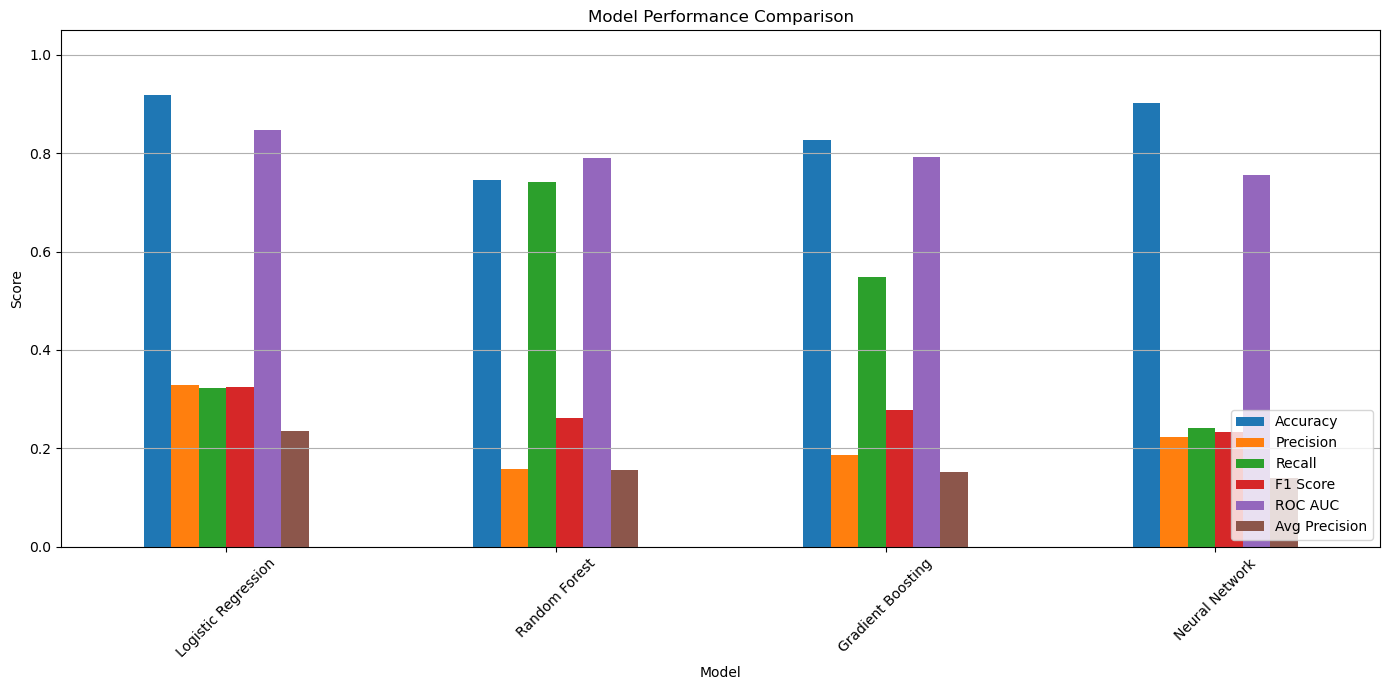

In [29]:
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Avg Precision']

results_df.set_index("Model")[metrics_to_plot].plot(kind='bar', figsize=(14, 7))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 4. Model Optimization:

In [33]:
rf = RandomForestClassifier(random_state=42)

random_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30]
}

rf_random_search = RandomizedSearchCV(estimator=rf,
                                      param_distributions=random_grid,
                                      n_iter=30,
                                      cv=5,
                                      random_state=42,
                                      scoring='f1')

rf_random_search.fit(X_train, y_train)

print("Best parameters from Random Search:")
print(rf_random_search.best_params_)


Best parameters from Random Search:
{'n_estimators': 100, 'max_depth': None}


In [35]:
param_grid = {
    'n_estimators': [rf_random_search.best_params_['n_estimators']],
}

# Only include max_depth in param_grid if it's not None in best_params_
if rf_random_search.best_params_['max_depth'] is not None:
    param_grid['max_depth'] = [
        rf_random_search.best_params_['max_depth'] - 5,
        rf_random_search.best_params_['max_depth']
    ]
else:
    # You might want to specify some reasonable range if best was None
    param_grid['max_depth'] = [5, 10, None]  # Example values

rf_grid_search = GridSearchCV(estimator=rf,
                            param_grid=param_grid,
                            cv=5,
                            scoring='f1')

rf_grid_search.fit(X_train, y_train)
best_model = rf_grid_search.best_estimator_

print("Best parameters from Grid Search:")
print(rf_grid_search.best_params_)

y_pred = rf_grid_search.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best parameters from Grid Search:
{'max_depth': None, 'n_estimators': 100}
Confusion Matrix:
 [[960   0]
 [ 62   0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.00      0.00      0.00        62

    accuracy                           0.94      1022
   macro avg       0.47      0.50      0.48      1022
weighted avg       0.88      0.94      0.91      1022



In [37]:
import pickle

In [39]:
pickle.dump(best_model, open('stroke_model.pkl', 'wb'))

In [41]:
# Save the feature columns used during training
columns = X.columns
with open('model_columns.pkl', 'wb') as f:
    pickle.dump(columns, f)


In [43]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open('scaler.pkl', 'wb'))  # Save it